In [110]:
import numpy as np
import matplotlib.pyplot as plt
from dataloader import RadarImageTargetSet
from sklearn.model_selection import StratifiedKFold
ds = RadarImageTargetSet()

In [111]:
boxes = []
for (img, tgt) in ds:
    for box in tgt['boxes']:
        boxes.append(box)
boxes = np.array(boxes)
box_xsizes = boxes[:, 2] - boxes[:, 0]
box_ysizes = boxes[:, 3] - boxes[:, 1]
max_x_size = int(max(box_xsizes))
max_y_size = int(max(box_ysizes))

print(max_x_size, max_y_size)

11 27


In [112]:
# prepare training data for DopplerNet like model

x = []
y = []
for (img, tgt) in ds:
    #print(img.shape)
    for (class_type, (y0, x0, y1, x1)) in zip(tgt['labels'], list(tgt['boxes'])):
        # cut box out of image
        #print(class_type)
        #print(x0, y0, x1, y1)
        cutout = img[int(x0):int(x1), int(y0):int(y1)]
        #print(cutout.shape)
        if cutout.shape[0] > max_x_size and cutout.shape[1] > max_y_size:
            print("can't process box of shape", x0, y0, x1, y1, cutout.shape)
            continue
        # padding putting it in upper left corner
        # TODO: center
        y_padding = int(max_y_size - cutout.shape[0])
        x_padding = int(max_x_size - cutout.shape[1])
        padded = np.pad(cutout, ((y_padding // 2, y_padding - (y_padding // 2)), (x_padding // 2, x_padding - (x_padding // 2))), mode='constant', constant_values=0.0)
        x.append(padded)
        # class as one hot encoding
        y.append([1.0 if int(class_type) == i else 0.0 for i in range(4)])

x = np.array(x)
y = np.array(y)
print(x.shape)
print(y.shape)

(594, 27, 11)
(594, 4)


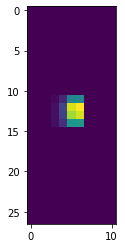

In [113]:
plt.imshow(x[28])

In [114]:
from sklearn.model_selection import train_test_split 
x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.33, random_state=42)

x_train=np.asarray(x_train)
y_train=np.asarray(y_train)
x_test=np.asarray(x_test)
y_test=np.asarray(y_test)
x_train=np.reshape(x_train,[-1,11,27,1])
x_test=np.reshape(x_test,[-1,11,27,1])

In [2]:
import tensorflow as tf
import tensorflow.keras as k

model=k.Sequential()
model.add(tf.keras.Input(shape=(11,27,1)))
model.add(k.layers.Conv2D(32,3,3,padding='valid',
    dilation_rate=(1, 1),
    activation="relu"))
model.add(k.layers.Flatten())
model.add(k.layers.Dense(64,activation="relu"))
#model.add(k.layers.Dense(64,activation="relu"))
#model.add(k.layers.Dense(64,activation="relu"))
model.add(k.layers.Dense(64,activation="relu"))
model.add(k.layers.Dense(4,activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
#TODO: parallel input of absolute box position 

# define two sets of inputs
inputA = Input(shape=(11,27,1))
inputB = Input(shape=(2,))
# the first branch operates on the first input
x = k.layers.Conv2D(32,3,3,padding='valid',
    dilation_rate=(1, 1),
    activation="relu")(inputA)
x = k.layers.Flatten(x)#
x = Model(inputs=inputA, outputs=x)
# the second branch opreates on the second input
#y = Dense(1, activation="linear")(inputB)
y = Model(inputs=inputB, outputs=inputB)
# combine the output of the two branches
combined = concatenate([x.output, y.output])
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(64, activation="relu")(combined)
z = Dense(32, activation="relu")(combined)
z = Dense(4, activation="softmax")
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 3, 9, 32)          320       
_________________________________________________________________
flatten_1 (Flatten)          (None, 864)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                55360     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 4)                

In [116]:
EPOCHS = 25
history=model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=EPOCHS,batch_size=374) 
# set batch size to number of images in dataset ==> slower training but minority class is consicerd in every parameter update

Epoch 1/50
2/2 [==============================] - 1s 356ms/step - loss: 40.8324 - accuracy: 0.4181 - val_loss: 12.8184 - val_accuracy: 0.5888
Epoch 2/50
2/2 [==============================] - 0s 134ms/step - loss: 18.5098 - accuracy: 0.5441 - val_loss: 9.3663 - val_accuracy: 0.5888
Epoch 3/50
2/2 [==============================] - 0s 80ms/step - loss: 12.7163 - accuracy: 0.5441 - val_loss: 5.9485 - val_accuracy: 0.5990
Epoch 4/50
2/2 [==============================] - 0s 88ms/step - loss: 7.7078 - accuracy: 0.5768 - val_loss: 3.5296 - val_accuracy: 0.6142
Epoch 5/50
2/2 [==============================] - 0s 113ms/step - loss: 4.5309 - accuracy: 0.6045 - val_loss: 3.2137 - val_accuracy: 0.6548
Epoch 6/50
2/2 [==============================] - 0s 85ms/step - loss: 3.3903 - accuracy: 0.6171 - val_loss: 2.9039 - val_accuracy: 0.6142
Epoch 7/50
2/2 [==============================] - 0s 104ms/step - loss: 2.5016 - accuracy: 0.6373 - val_loss: 2.4119 - val_accuracy: 0.5838
Epoch 8/50
2/2 [===

In [117]:
y_pred=history.model.predict(x_test)



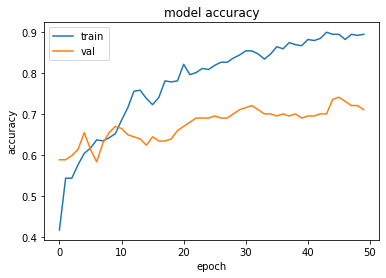

In [118]:
#plt.plot(range(1,EPOCHS+1),history.history['loss'], label='validation loss')

#plt.plot(range(1,EPOCHS+1),history.history['accuracy'], label='validation accuracy')
#plt.legend()
#plt.show()

# plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

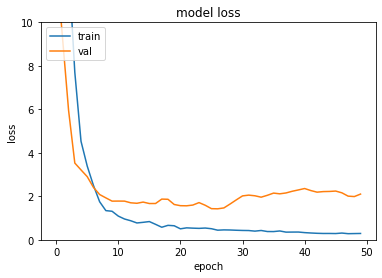

In [123]:
# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim((0, 10))
plt.show()

In [120]:
history.model.evaluate(x_test,y_test)

7/7 [==============================] - 0s 14ms/step - loss: 2.1023 - accuracy: 0.7107


[2.1023433208465576, 0.710659921169281]

(197, 4)

[[ 0  1  0  0]
 [ 0  9  6  4]
 [ 0  6 95 15]
 [ 0  8 17 36]]


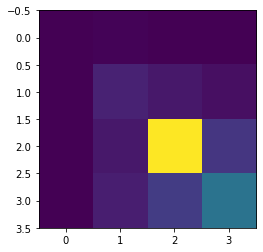

In [121]:
from sklearn.metrics import confusion_matrix
y_pred_abs = np.argmax(y_pred, axis=1)
y_test_abs = np.argmax(y_test, axis=1)
cm=confusion_matrix(y_test_abs,y_pred_abs)
plt.imshow(cm)
print(cm)

In [122]:
# 10-fold cross validation
if __name__ == "__main__":
    n_folds = 10
    data, labels, header_info = load_data()
    skf = StratifiedKFold(labels, n_folds=n_folds, shuffle=True)

    for i, (train, test) in enumerate(skf):
            print("Running Fold", i+1, "/", n_folds)
            model = None # Clearing the NN.
            model = create_model()
            train_and_evaluate_model(model, data[train], labels[train], data[test], labels[test])

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (<ipython-input-122-d878b0396607>, line 11)